# Customer Analysis and Segmentation

In this notebook we perform clustering based on some anonymous customer data. We use a K-means clustering algorithm, and subsequently analyse the results. Here, we're analysing customer spending on an unidentified set of products, using the background of our customers to cluster by.

## EDA 
We'll start by importing the usual packages, as well as our cluster algo from Scikit-Learn. This section focuses on gaining an understanding of our data.

In [34]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

import seaborn as sns 

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import datetime
import warnings
warnings.filterwarnings("ignore")
import os

In [35]:
data = pd.read_csv('input/cust_data.csv')

In [36]:
print(data.shape)
data.head()

(60856, 5)


,id,credit_score,income,no_accounts,total_amount
0,00022759-5c63-4f0a-825a-747b3162c083,661,46000,6,7500.0
1,00028089-6879-499e-a14f-bddb02b9844a,669,5000,6,1149.0
2,0002c91c-c795-425e-9182-0ba6b73d3e5e,632,5000,3,1169.1
3,0004a4cf-edbc-4318-9fdb-1d485aa938bf,599,15000,6,450.0
4,00050339-896d-4628-a3e8-03b0409f61b6,571,35000,1,649.0


There are a few categorical vars that we'll need to sort. Also we can drop the id feature right away.

In [37]:
data.drop('id', axis=1, inplace=True)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60856 entries, 0 to 60855
Data columns (total 4 columns):
credit_score    60856 non-null int64
income          60856 non-null int64
no_accounts     60856 non-null int64
total_amount    60856 non-null float64
dtypes: float64(1), int64(3)
memory usage: 1.9 MB


In [39]:
data.describe()

,credit_score,income,no_accounts,total_amount
count,60856.000000,60856.000000,60856.000000,60856.00000
mean,594.496993,27759.895984,7.118706,1449.57227
std,58.281092,19675.417976,4.147016,1498.57997
min,432.000000,0.000000,0.000000,16.98000
25%,546.000000,15000.000000,4.000000,599.00000
50%,590.000000,25000.000000,7.000000,779.80000
75%,643.000000,35000.000000,10.000000,1889.00000
max,731.000000,673000.000000,36.000000,19800.00000


## Data Preproccessing
Here we transform and scale our features and look for anomalies or outliers. These steps are necessary to a high performing algorithm, and should often be revisited even after the algorithm has been fitted. 

Let's plot our new processed data to look for any interesting first signs

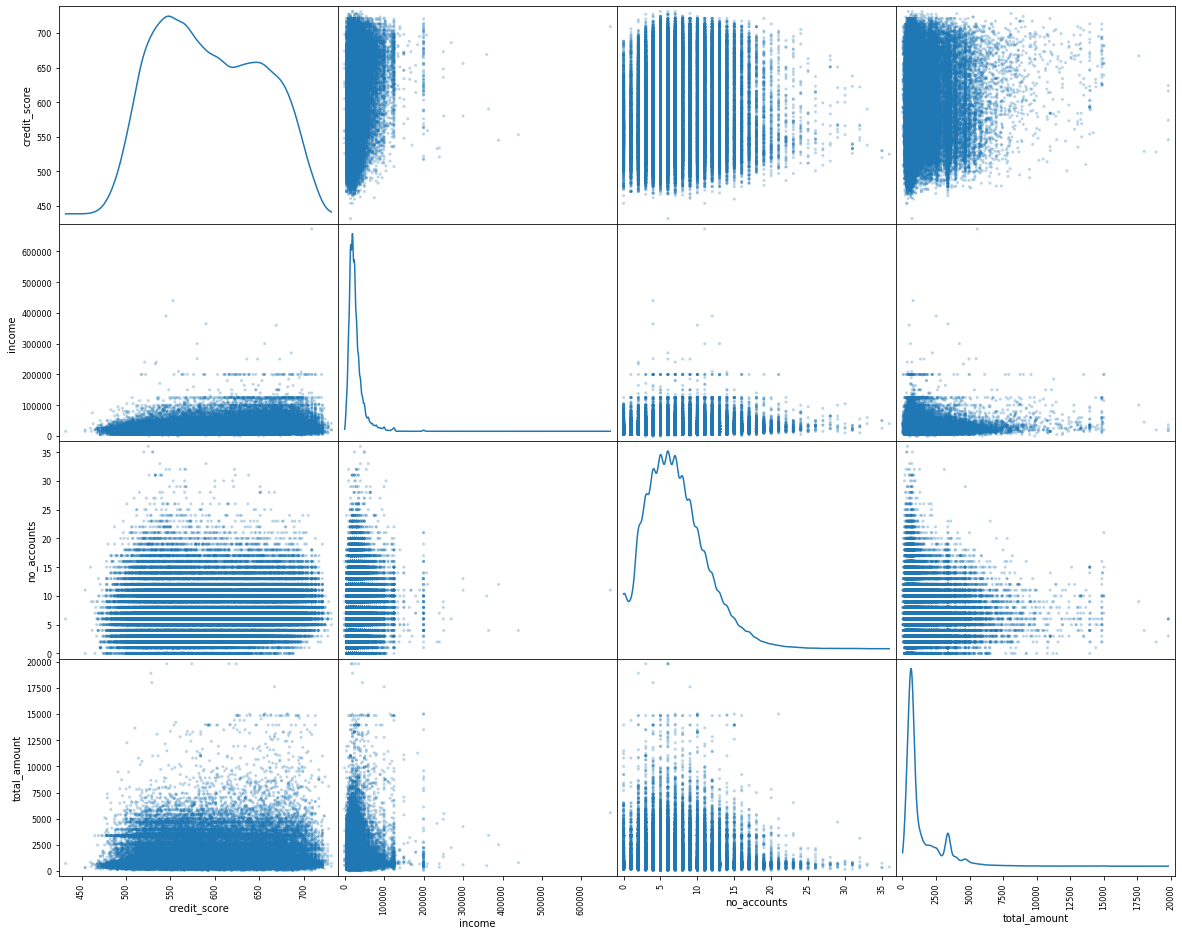

In [7]:
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (20,16), diagonal = 'kde');

Our K-Nearest Neighbours algorithm has to take in scaled data, or it won't perform particularly well. (Send me your thoughts if you disagree). Our data could be skewed by those zero values in features such as credit_score and credit_amount. We can't normalise by logarithm (as the zero values will return NaNs) but we also don't want to get rid of these data because they might be indicitive of some specific clusters. 

We will Robust Scaling instead (transform the feature vector by subtracting the median and then dividing by the interquartile range). This method is chosen because (as the name would suggest) it is more robust to outliers, due to its use of the median.



In [40]:
robust = RobustScaler()
df_scaled = pd.DataFrame(robust.fit_transform(data), columns=data.columns)

In [41]:
df_scaled.head()

,credit_score,income,no_accounts,total_amount
0,0.731959,1.05,-0.166667,5.209457
1,0.814433,-1.00,-0.166667,0.286202
2,0.432990,-1.00,-0.666667,0.301783
3,0.092784,-0.50,-0.166667,-0.255659
4,-0.195876,0.50,-1.000000,-0.101395


In [42]:
df_scaled.describe()

,credit_score,income,no_accounts,total_amount
count,60856.000000,60856.000000,60856.000000,60856.000000
mean,0.046361,0.137995,0.019784,0.519203
std,0.600836,0.983771,0.691169,1.161690
min,-1.628866,-1.250000,-1.166667,-0.591333
25%,-0.453608,-0.500000,-0.500000,-0.140155
50%,0.000000,0.000000,0.000000,0.000000
75%,0.546392,0.500000,0.500000,0.859845
max,1.453608,32.400000,4.833333,14.744341


## Principal Component Analysis
Here we discover what dimensions about the data maximize the variance of features involved. PCA will also tell us the explained variance ratio of each dimension. This is how much variance within the data is explained by that dimension alone.

In [43]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2, random_state = 0)
pca = pca.fit(df_scaled)

# Transform the good data using the PCA fit above
df_reduced = pca.transform(df_scaled)

# Create a DataFrame for the reduced data
df_reduced = pd.DataFrame(df_reduced, columns = ['Dimension 1', 'Dimension 2'])

In [44]:
df_reduced.head()

,Dimension 1,Dimension 2
0,4.648081,1.274022
1,-0.147860,-0.949776
2,-0.100235,-1.133458
3,-0.724030,-0.677232
4,-0.562698,0.057650


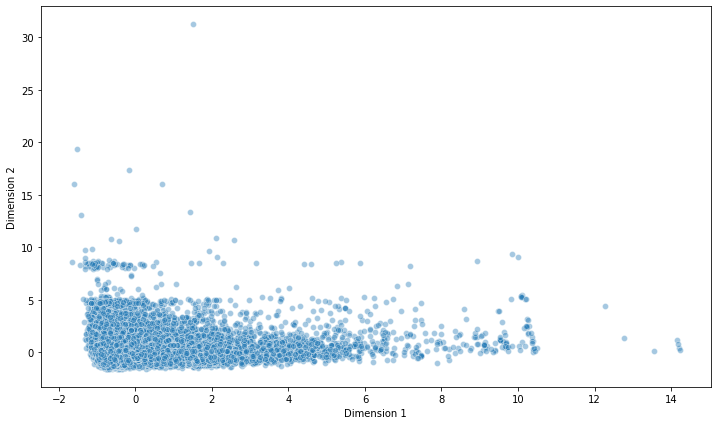

In [67]:
sns.scatterplot(df_reduced['Dimension 1'], df_reduced['Dimension 2'], alpha=0.4)
plt.show()

## Modelling

In [46]:
# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,10)
kmeans_results = {}
for size in num_clusters:
    kmeans = KMeans(n_clusters = size).fit(df_reduced)
    preds = kmeans.predict(df_reduced)
    kmeans_results[size] = silhouette_score(df_reduced, preds, sample_size=10000, metric='euclidean')

In [47]:
best_size = max(kmeans_results, key=kmeans_results.get)

# Build a model with the optimal number of clusters
optimized_kmeans = KMeans(n_clusters = best_size).fit(df_reduced)
kmeans_preds = optimized_kmeans.predict(df_reduced)
# Reports the centers of each cluster
kmeans_centers = optimized_kmeans.cluster_centers_
# Report the best silhouette score 
kmeans_score = silhouette_score(df_reduced, preds, sample_size=10000, metric='euclidean')

kmeans_assignment = optimized_kmeans.predict(df_reduced)

In [48]:
kmeans_results

{2: 0.5357646892030477,
 3: 0.5418770681773967,
 4: 0.5437745324974547,
 5: 0.4675710202146635,
 6: 0.4685976298903595,
 7: 0.4214027859115926,
 8: 0.4262413733217134,
 9: 0.40634199614094485}

According to our clustering algorithm, we should segment our customers into 4 segments

In [53]:
df_pred = pd.concat([df_reduced, pd.DataFrame(kmeans_preds, columns=['pred'])], axis=1)

In [55]:
df_pred.head()

,Dimension 1,Dimension 2,pred
0,4.648081,1.274022,2
1,-0.147860,-0.949776,3
2,-0.100235,-1.133458,3
3,-0.724030,-0.677232,3
4,-0.562698,0.057650,3


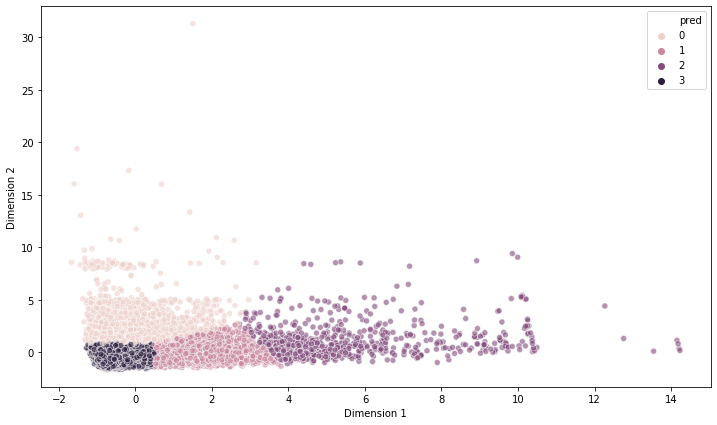

In [68]:
sns.scatterplot(x=df_pred['Dimension 1'], y=df_pred['Dimension 2'], alpha=0.6, hue=df_pred['pred'])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()